In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()
import math
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import log_loss, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer, OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier

import time

In [64]:
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')

In [65]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [66]:

def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [67]:
summary(train)

data shape: (7905, 20)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.0,7905,0.0,7904.0,0,1,2
N_Days,int64,0,0.0,461,41.0,4795.0,999,2574,3428
Drug,object,0,0.0,2,NaN,NaN,D-penicillamine,Placebo,Placebo
Age,int64,0,0.0,391,9598.0,28650.0,21532,19237,13727
Sex,object,0,0.0,2,NaN,NaN,M,F,F
Ascites,object,0,0.0,2,NaN,NaN,N,N,N
Hepatomegaly,object,0,0.0,2,NaN,NaN,N,N,Y
Spiders,object,0,0.0,2,NaN,NaN,N,N,Y
Edema,object,0,0.0,3,NaN,NaN,N,N,Y
Bilirubin,float64,0,0.0,111,0.3,28.0,2.3,0.9,3.3


In [68]:
train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

In [69]:
train.Drug.value_counts()

Drug
Placebo            4010
D-penicillamine    3895
Name: count, dtype: int64

In [70]:
train.Edema.value_counts()

Edema
N    7161
S     399
Y     345
Name: count, dtype: int64

In [71]:
train.Status.value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

Основные сведения:
* В наборах данных нет пропущенных значений.
* В наборе данных нет повторяющихся значений.
* Целевой "Status" поставляется с тремя уникальными значениями (C, CL, D), которые необходимо закодировать меткой или применить onehot для дальнейшего прогнозирования.
* Если есть необходимость в преобразовании двоичных объектов или категориальных объектов, таких как True или False, то onehot.

# EDA

In [72]:
# выбираем числовые и категориальные переменные
num_cols = train.select_dtypes(include=['int', 'float'])
cat_cols = train.select_dtypes(include=['object'])

In [73]:
fig2 = px.pie(train, names='Status', 
             height=400, width=600, 
             hole=0.7, 
             title='target class Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#ffffff', paper_bgcolor='#ffffff',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

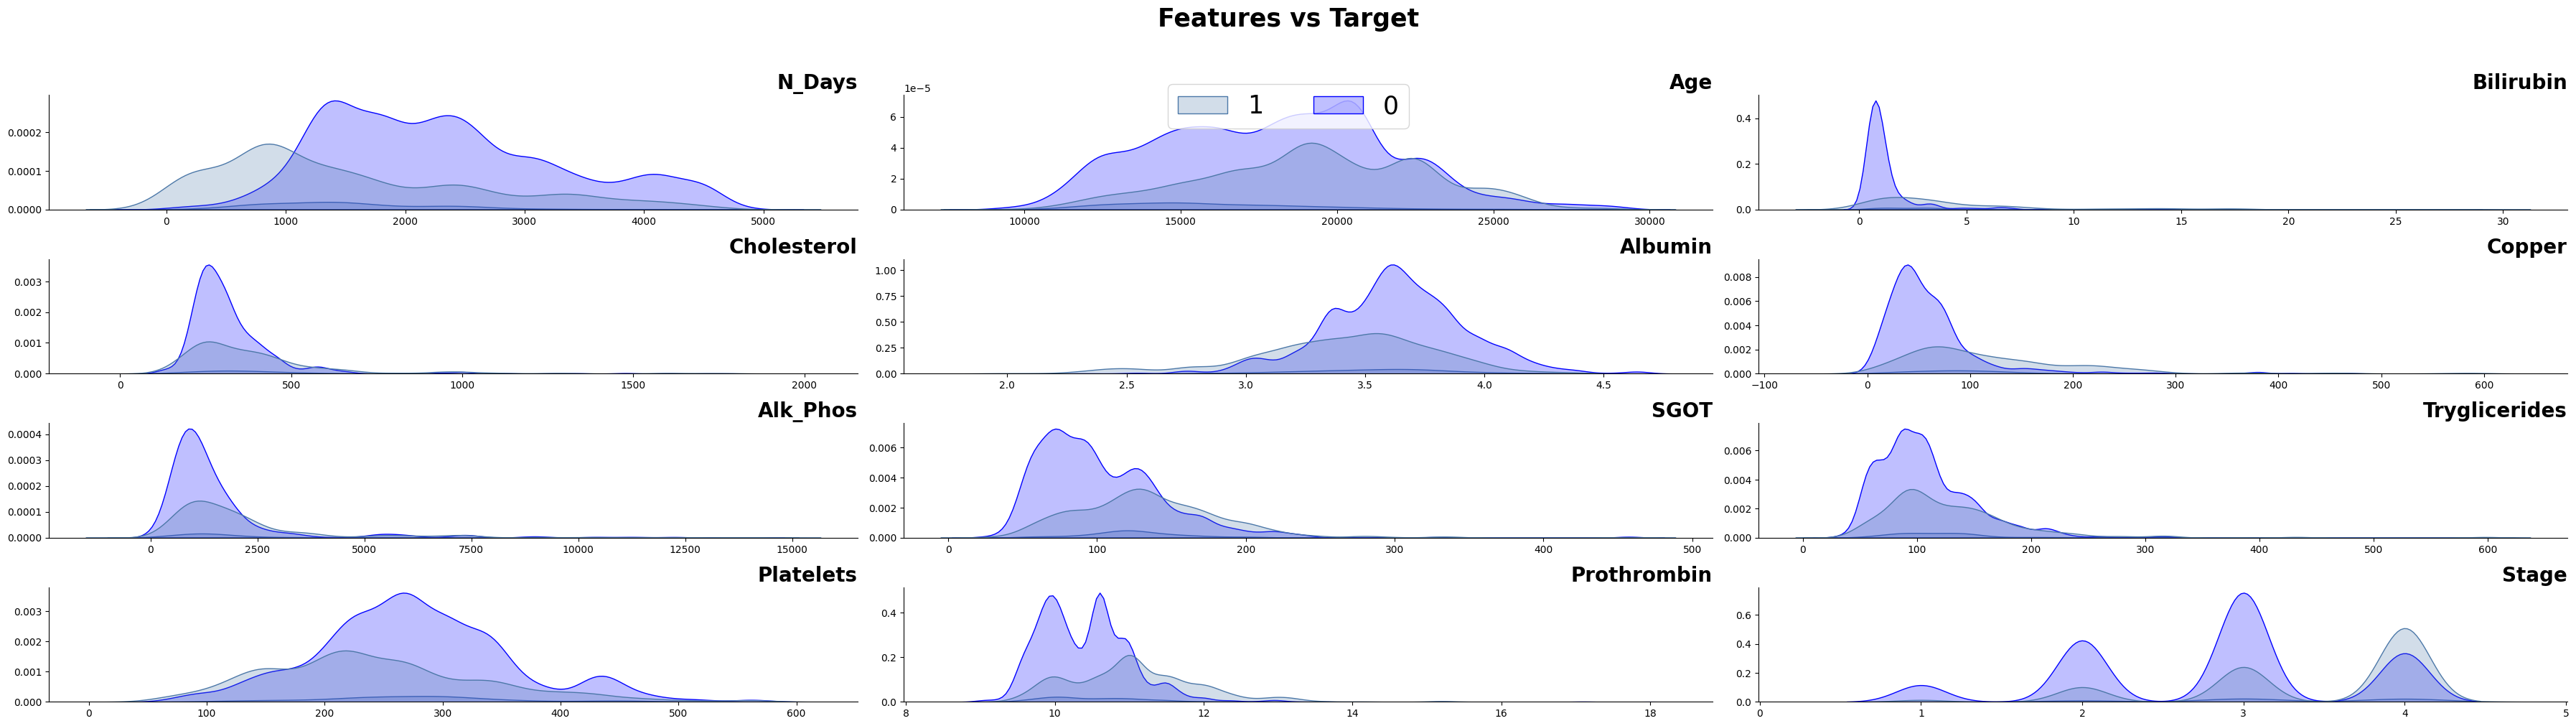

CPU times: user 7.54 s, sys: 4.2 s, total: 11.7 s
Wall time: 4.83 s


In [74]:
%%time
figsize = (6*6, 45)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols.columns):
    ax = plt.subplot(19,3, idx + 1)
    sns.kdeplot(
        data=train, hue='Status', fill=True,
        x=col, palette=['#4c78a8', 'blue'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()
plt.show()


In [75]:
cat_cols = train.select_dtypes(include = ['object']).astype('category')
cat_cols.head()

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
0,D-penicillamine,M,N,N,N,N,D
1,Placebo,F,N,N,N,N,C
2,Placebo,F,N,Y,Y,Y,D
3,Placebo,F,N,N,N,N,C
4,Placebo,F,N,Y,N,N,C


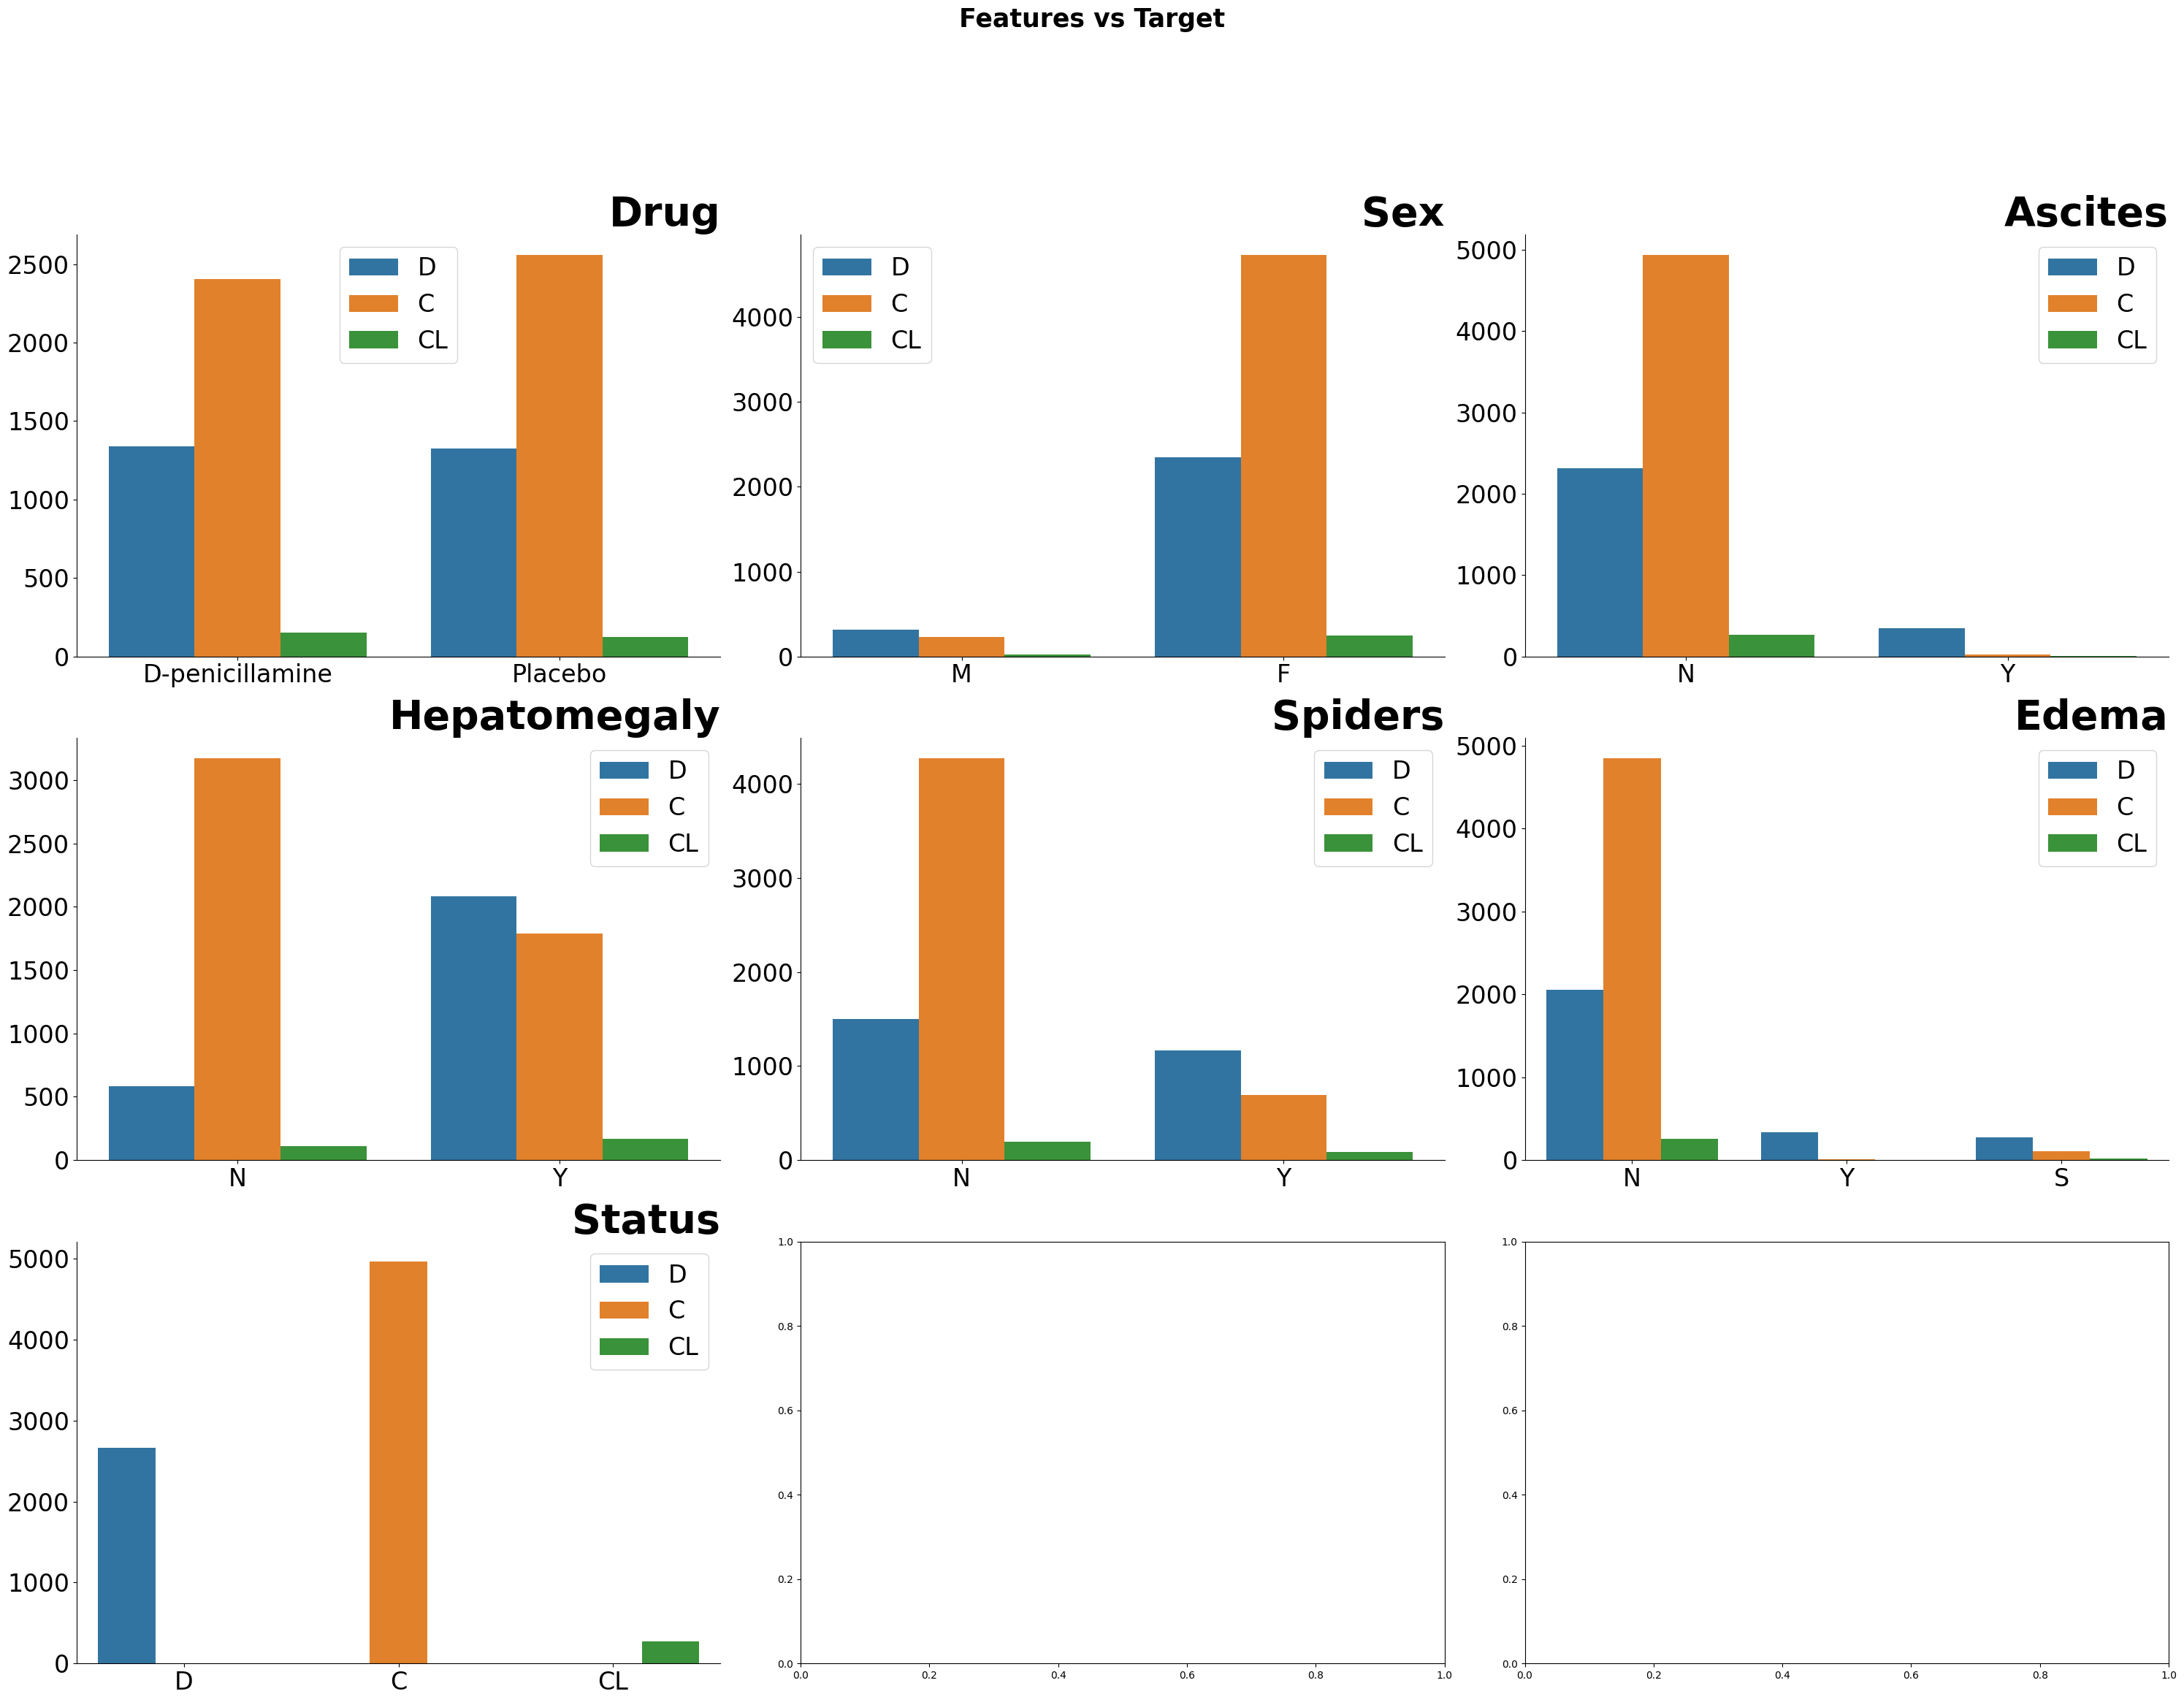

CPU times: user 5.48 s, sys: 2.05 s, total: 7.54 s
Wall time: 4 s


In [76]:
%%time
figsize = (3*10, 25)
fig, axes = plt.subplots(3, 3, figsize=figsize)
fig.suptitle(f'Features vs Target\n\n\n', ha='center', fontweight='bold', fontsize=25)

for idx, col in enumerate(cat_cols.columns):
    row, col_num = divmod(idx, 3)
    ax = axes[row, col_num]
    
    sns.countplot(data=train, x=col, hue='Status', ax=ax)
    
    ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', weight='bold', fontsize=40)
    ax.tick_params(axis='both', labelsize=24)
    ax.legend(fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

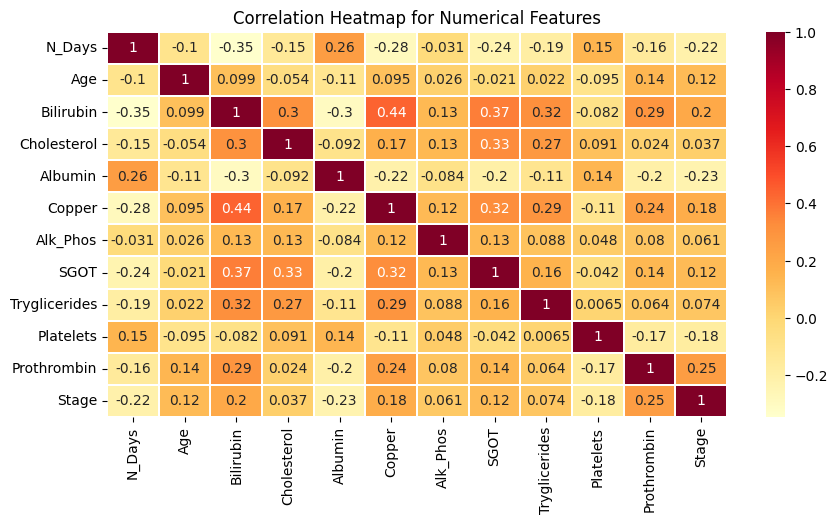

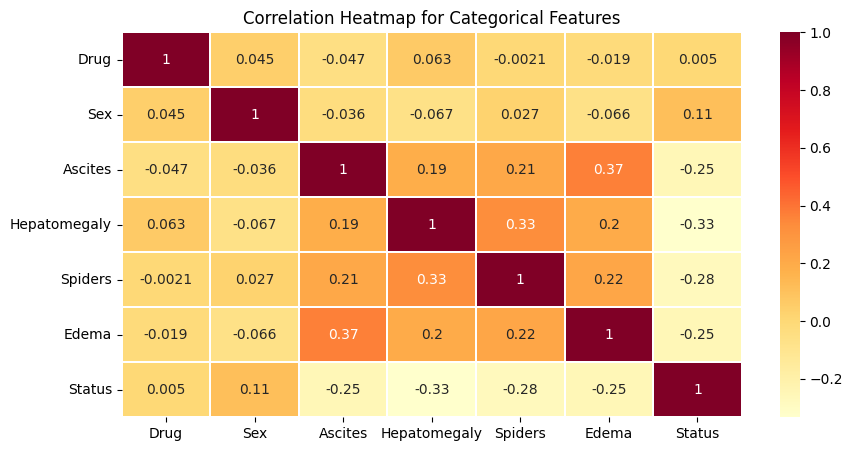

In [77]:
# Создание тепловой карты корреляции для числовых признаков
corr_num = train[num_cols.columns].corr()

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corr_num, annot=True, cmap='YlOrRd', linewidths=.3)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

# Создание тепловой карты корреляции для категориальных признаков
corr_cat = train[cat_cols.columns].apply(lambda x: x.factorize()[0]).corr()

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corr_cat, annot=True, cmap='YlOrRd', linewidths=.3)
plt.title('Correlation Heatmap for Categorical Features')
plt.show()

# Features

In [78]:
LABEL = "Status"
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in train.columns if x not in CAT_FEATS and x != LABEL]

df_train_mod = train.copy()
df_test_mod = test.copy()

print(f"Train shape: {df_train_mod.shape}")
print(f"Test shape: {df_test_mod.shape}")
assert df_train_mod.shape[1]-1 == df_test_mod.shape[1]

Train shape: (7905, 19)
Test shape: (5271, 18)


In [79]:
label_encoder = LabelEncoder()
df_train_mod[LABEL] = label_encoder.fit_transform(df_train_mod[LABEL])

In [80]:
encoders = {
    'Drug': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[['Placebo', 'D-penicillamine']]),
    'Sex': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Ascites': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Hepatomegaly': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Spiders': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Edema': OneHotEncoder(),
    'Stage': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
}

In [81]:
for feat, enc in encoders.items():
    if isinstance(enc, OrdinalEncoder):
        df_train_mod[feat] = enc.fit_transform(df_train_mod[[feat]]).astype('int32')
        df_test_mod[feat] = enc.transform(df_test_mod[[feat]]).astype('int32')
    if isinstance(enc, OneHotEncoder):
        # Transform and get new column names
        new_cols = enc.fit_transform(df_train_mod[[feat]]).toarray().astype('int8')
        # col_names = [f"{feat}_{cat}" for cat in enc.categories_[0]]
        col_names = enc.get_feature_names_out()
        
        # Add new columns to the dataframe
        df_train_mod[col_names] = new_cols
        df_train_mod.drop(feat, axis=1, inplace=True)  # Drop original column
        
        # Repeat for the test set
        new_cols_test = enc.transform(df_test_mod[[feat]]).toarray().astype('int8')
        df_test_mod[col_names] = new_cols_test
        df_test_mod.drop(feat, axis=1, inplace=True)

In [82]:
df_train_mod

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,...,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y
0,999,1,21532,1,0,0,0,2.3,316.0,3.35,...,1601.0,179.80,63.0,394.0,9.7,2,2,1,0,0
1,2574,0,19237,0,0,0,0,0.9,364.0,3.54,...,1440.0,134.85,88.0,361.0,11.0,2,0,1,0,0
2,3428,0,13727,0,0,1,1,3.3,299.0,3.55,...,1029.0,119.35,50.0,199.0,11.7,3,2,0,0,1
3,2576,0,18460,0,0,0,0,0.6,256.0,3.50,...,1653.0,71.30,96.0,269.0,10.7,2,0,1,0,0
4,788,0,16658,0,0,1,0,1.1,346.0,3.65,...,1181.0,125.55,96.0,298.0,10.6,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,1,16839,0,0,0,0,0.8,309.0,3.56,...,1629.0,79.05,224.0,344.0,9.9,1,0,1,0,0
7901,1492,0,17031,0,0,1,0,0.9,260.0,3.43,...,1440.0,142.00,78.0,277.0,10.0,3,0,1,0,0
7902,1576,1,25873,0,0,0,1,2.0,225.0,3.19,...,933.0,69.75,62.0,200.0,12.7,1,2,0,1,0
7903,3584,1,22960,1,0,1,0,0.7,248.0,2.75,...,1003.0,57.35,118.0,221.0,10.6,3,2,1,0,0


| Класс трансформатора           | Тип  | Описание                                                                                                                                                                         |
| ------------------------------ | ---- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| DiagnosisDateTransformer       | num  | Рассчитывает 'Diagnosis_Date', вычитая 'N_Days' из 'Age'. Это может предоставить более прямую меру времени с момента диагноза, важную для анализа.                              |
| AgeBinsTransformer             | cat  | Категоризирует 'Age' по интервалам (19, 29, 49, 64, 99), преобразуя непрерывную переменную в категориальную для упрощенного анализа.                                              |
| BilirubinAlbuminTransformer    | num  | Создает новый признак 'Bilirubin_Albumin', умножая 'Bilirubin' на 'Albumin', что может выявить взаимодействия между этими двумя переменными.                                      |
| NormalizeLabValuesTransformer  | num  | Нормализует лабораторные значения (такие как 'Bilirubin', 'Cholesterol', и т.д.) до их z-оценок, стандартизируя эти признаки для целей моделирования.                                |
| DrugEffectivenessTransformer   | num  | Создает новый признак 'Drug_Effectiveness' путем комбинирования 'Drug' и уровней 'Bilirubin'. Предполагается, что изменения в 'Bilirubin' отражают эффективность препарата.     |
| SymptomScore(Cat)Transformer   | num  | Суммирует наличие симптомов ('Ascites', 'Hepatomegaly' и т.д.) в единую 'Symptom_Score', упрощая представление симптомов пациента.                                             |
| LiverFunctionTransformer       | num  | Рассчитывает 'Liver_Function_Index' как среднее ключевых тестов на функцию печени, предоставляя комплексную метрику для оценки здоровья печени.                                    |
| RiskScoreTransformer           | num  | Рассчитывает 'Risk_Score' с использованием комбинации 'Bilirubin', 'Albumin' и 'Alk_Phos', предлагая потенциальную композитную оценку риска для пациентов.                        |
| TimeFeaturesTransformer        | num  | Извлекает 'Year' и 'Month' из 'N_Days', преобразуя непрерывную меру времени в более интерпретируемые категориальные временные единицы.                                           |

In [83]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline

class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 365).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Use years from above, min=26, max=78
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    # Placeholder concept, assuming 'Bilirubin' improvement is a measure of effectiveness
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    # From data set explanations above let's add all the "bad" symptoms
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])

        # Drop the original symptom columns and add the new encoded features
        # X_transformed.drop(columns=self.symptom_columns, inplace=True)
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

# Define the pipeline
pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('age_groups', AgeGroupsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer()),
   ])

# Apply the pipeline to your dataframes
df_train_mod = pipeline.fit_transform(df_train_mod)
df_test_mod = pipeline.transform(df_test_mod)

# Update the CAT_FEATS
CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', #old
             'Age_Group', 'Symptom_Score']

# Outlier Detection & Removal

Значения, которые составляют более 6 стандартных отклонений от среднего, считаются выбросами, и их нужно  удалить.

In [84]:
tmp_df = df_train_mod.copy()

# Calculate the mean and standard deviation for each column
means = tmp_df[NUM_FEATS].mean()
std_devs = tmp_df[NUM_FEATS].std()

# Define a threshold for what you consider to be an outlier, typically 3 standard deviations from the mean
n_stds = 6
thresholds = n_stds * std_devs

# Detect outliers
outliers = (np.abs(tmp_df[NUM_FEATS] - means) > thresholds).any(axis=1)

print(f"Detected {sum(outliers)} that are more than {n_stds} SDs away from mean...")

Detected 166 that are more than 6 SDs away from mean...


In [85]:
# The resulting boolean series can be used to filter out the outliers
outliers_df = tmp_df[outliers]

# Overwrite the train data
df_train_mod = tmp_df[~outliers].reset_index(drop=True)
print(f"Train data shape after outlier removal: {df_train_mod.shape}")

Train data shape after outlier removal: (7739, 55)


# LGBM model

In [86]:
# Определим параметры для подбора
#params_lgbm = {
    #'colsample_bytree': np.arange(0.3, 1, 0.05),
    #'learning_rate': np.linspace(0.1, 0.5, 50), # 50 значений от 0.1 до 0.5
    #'max_depth': np.arange(2, 15, 1), # от 2 до 15 с шагом 1
    #'reg_alpha': np.linspace(0, 2e-07, 100),
    #'reg_lambda': np.linspace(0, 3e-07, 100),
    #'n_estimators': np.arange(100, 3000, 100),
    #'subsample': np.arange(0.3, 1, 0.05)}
# Создадим объект LGBMRegressor с параметрами по умолчанию и random_state для воспроизводимости
#regressor_lgbm = LGBMClassifier(random_state=42)

# Создадим объект RandomizedSearchCV для поиска оптимальных значений параметров
#search = RandomizedSearchCV(
    #estimator=regressor_lgbm,
    #param_distributions=params_lgbm,
    #n_iter=100,
    #scoring='neg_mean_squared_error',
    #cv=5,
    #random_state=42,
    #n_jobs=-1,
   #verbose=1)

# Запустим поиск оптимальных значений параметров на обучающих данных
#search.fit(X,y)

# Выведем лучшие значения параметров
#best_params_lgbm = search.best_params_ # словарь с лучшими значениями параметров
#print(f'Best parameters lgbm: {best_params_lgbm}')

In [87]:
FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
         'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 
         'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']
print(f"Number of feats: {len(FEATS)}")

Number of feats: 21


In [88]:
df_train_final = df_train_mod[FEATS + [LABEL]]
df_test_final = df_test_mod[FEATS]

In [89]:
import lightgbm as lgb
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import log_loss

data = df_train_final
label = 'Status'
feats = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
         'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 
         'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']

lgb_params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3,
    'n_estimators': 200,
    'max_depth': 3,
    'learning_rate': 0.10816326530612246,
    'reg_alpha': 1.69e-07,
    'reg_lambda': 2.45e-07,
    'min_child_weight': 1,
    'min_child_samples': 99,
    'subsample': 0.95,
    'subsample_freq': 0,
    'colsample_bytree': 0.55,
    'num_leaves': 50,
    'random_state': 42
}

n_splits = 5
n_repeats = 1
seed = 42

train_scores = []
val_scores = []

skf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

for i, (train_idx, val_idx) in enumerate(skf.split(data[feats], data[label])):
    X_train, y_train = data[feats].loc[train_idx], data[label].loc[train_idx]
    X_val, y_val = data[feats].loc[val_idx], data[label].loc[val_idx]

    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    train_preds = model.predict_proba(X_train)
    valid_preds = model.predict_proba(X_val)
    train_score = log_loss(y_train, train_preds)
    val_score = log_loss(y_val, valid_preds)

    train_scores.append(train_score)
    val_scores.append(val_score)

    print(f"Fold {i + 1} | Train log_loss: {round(train_score, 4)} | Valid log_loss: {round(val_score, 4)}")

mean_val_score = np.mean(val_scores)
print(f"Mean validation log_loss: {round(mean_val_score, 4)}")

Fold 1 | Train log_loss: 0.3184 | Valid log_loss: 0.4555
Fold 2 | Train log_loss: 0.324 | Valid log_loss: 0.4478
Fold 3 | Train log_loss: 0.3273 | Valid log_loss: 0.426
Fold 4 | Train log_loss: 0.3202 | Valid log_loss: 0.4557
Fold 5 | Train log_loss: 0.3254 | Valid log_loss: 0.4377
Mean validation log_loss: 0.4445


# Оценка и визуализация

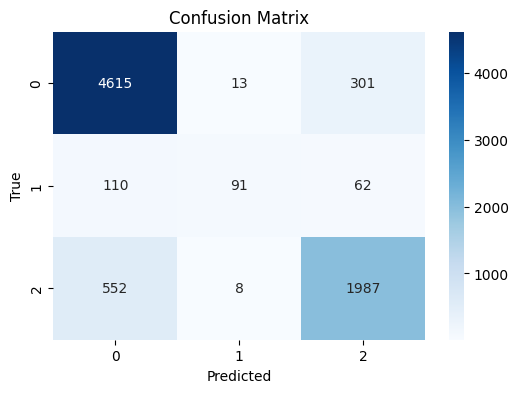

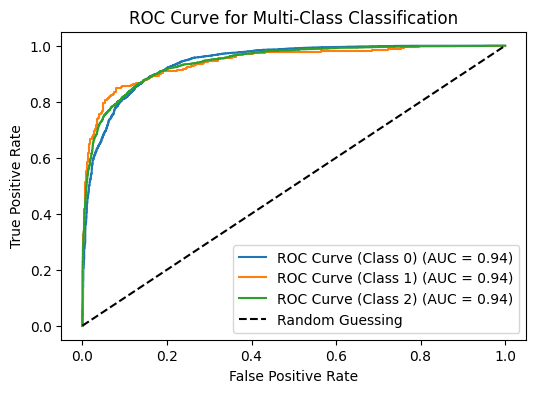

In [90]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

X_test, y_test = df_train_final[FEATS], df_train_final[LABEL]

# Получение предсказаний на тестовом наборе данных
test_preds = model.predict(X_test)
test_probs = model.predict_proba(X_test)


# Вычисление матрицы ошибок
cm = confusion_matrix(y_test, test_preds)

# Создать тепловую карту с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 10})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Построение кривой ROC для каждого класса
n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение кривой ROC
plt.figure(figsize=(6, 4))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC Curve (Class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()


# Probability Calibration

In [91]:
from sklearn.calibration import CalibratedClassifierCV

# Получение предсказанных вероятностей без калибровки
uncalibrated_preds = model.predict_proba(X_test)

# Вычисление log loss без калибровки
uncalibrated_log_loss = log_loss(y_test, uncalibrated_preds)
print(f'No calibration LogLoss: {uncalibrated_log_loss:.5f}')

# Создание экземпляра CalibratedClassifierCV для плетта (Platt scaling)
platt_model = CalibratedClassifierCV(model, cv='prefit', method='sigmoid')

# Обучение модели на тестовом наборе
platt_model.fit(X_test, y_test)

# Получение предсказанных вероятностей после калибровки плетта
platt_preds = platt_model.predict_proba(X_test)

# Вычисление log loss после калибровки плетта
platt_log_loss = log_loss(y_test, platt_preds)
print(f'Platt calibration LogLoss: {platt_log_loss:.5f}')

# Создание экземпляра CalibratedClassifierCV для изотонической регрессии
isotonic_model = CalibratedClassifierCV(model, cv='prefit', method='isotonic')

# Обучение модели на тестовом наборе
isotonic_model.fit(X_test, y_test)

# Получение предсказанных вероятностей после калибровки изотонической регрессией
isotonic_preds = isotonic_model.predict_proba(X_test)

# Вычисление log loss после калибровки изотонической регрессией
isotonic_log_loss = log_loss(y_test, isotonic_preds)
print(f'Isotonic calibration LogLoss: {isotonic_log_loss:.5f}')

No calibration LogLoss: 0.34789
Platt calibration LogLoss: 0.35194
Isotonic calibration LogLoss: 0.32983


Обнаружено, что изотоническая регрессия дает лучшую калибровку, чем масштабирование Платта. Результаты показали, что изотоническая регрессия привела к более низкому баллу логарифмической потери, чем логистическая регрессия после калибровки, что указывает на более точные оценки вероятности. Тем не менее, изотоническая регрессия имеет тенденцию к перенастройке калибровочной кривой, что может привести к нереалистичным скачкам

In [92]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')
sample_submission.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128


In [93]:
# Создание DataFrame с предсказаниями для тестового набора данных
test_preds_proba = model.predict_proba(df_test_final[feats])

# Создание DataFrame для сабмита
predictions_df = pd.DataFrame({
    'id': sample_submission['id'],
    'Status_C': test_preds_proba[:, 0],
    'Status_CL': test_preds_proba[:, 1],
    'Status_D': test_preds_proba[:, 2]
})

In [94]:
predictions_df

,id,Status_C,Status_CL,Status_D
0,7905,0.660058,0.018722,0.321220
1,7906,0.649596,0.152719,0.197684
2,7907,0.009569,0.003474,0.986957
3,7908,0.961297,0.005546,0.033157
4,7909,0.882869,0.022531,0.094601
...,...,...,...,...
5266,13171,0.924747,0.030462,0.044790
5267,13172,0.980178,0.002808,0.017014
5268,13173,0.915912,0.005566,0.078522
5269,13174,0.986242,0.004623,0.009135


In [95]:
predictions_df.to_csv('submission.csv', index=False)